### Dependencies 

In [2]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import os 
import matplotlib.pyplot as plt



### Split Train/Val data
###### si '.ipynb_checkpoints' est present, rm -r jetracer/notebooks/classification_TRAIN/.ipynb_checkpoints et verifier .gitignore

In [3]:
from torch.utils.data.sampler import SubsetRandomSampler
from meanstd import funct_meanstd

data_dir = 'classification_TRAIN'
mean,std = funct_meanstd(data_dir)

def load_split_train_test(datadir, valid_size = .3):
    
    

    train_transforms = transforms.Compose([
                transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
                transforms.Resize((224, 224)),
                #transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(degrees=5),
                transforms.ToTensor(),
                #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                #transforms.Normalize(mean, std)
            ])

    test_transforms = transforms.Compose([
                #transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                #transforms.Normalize(mean, std)
            ])

    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)

    print(train_data.classes)
    num_train=len(train_data)
    indices = list(range(num_train)) #on cree une liste de 0 a nbdonnées
    split = int(np.floor(valid_size * num_train)) #si valid size = 0.2 alors split = 20% du nombre de données
    np.random.shuffle(indices) #on melange la liste d'indices des donnés 
    train_idx, test_idx = indices[split:], indices[:split] #on sépare les indices de données selon le pourcentage de validation
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    
    trainloader = torch.utils.data.DataLoader(
                    train_data,
                    sampler=train_sampler, 
                    batch_size=32
                )
    testloader = torch.utils.data.DataLoader(
                    test_data,
                    sampler=test_sampler, 
                    batch_size=32
                )
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)


['Mug', 'Rline', 'Stapler', 'TennisBall', 'Thumbup']


### Try GPU avaibality 

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### (function to know how much pictures for classification)

In [5]:
somme=0
for i in os.listdir(data_dir):
    liste_cate = os.listdir(data_dir+'/'+i)
    somme+=len(liste_cate)
    print('number pictures in',str(i), len(liste_cate))
          
print('nb total image',somme)

number pictures in Stapler 137
number pictures in Rline 150
number pictures in Thumbup 151
number pictures in TennisBall 166
number pictures in Mug 155
nb total image 759


### Choose model

In [5]:
liste_cat = os.listdir(data_dir) #avoir une liste des dataset de classification (nombre categorie)
output_dim=len(liste_cat)

model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(512, output_dim)
#model.fc= nn.Sequential(nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.2), nn.Linear(256, output_dim),nn.LogSoftmax(dim=1))

loss_function=nn.CrossEntropyLoss()
#loss_function=nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(),lr=0.003)
model=model.to(device)
#print(model)

In [6]:
import time
from utils import preprocess
start_time=time.time()
epochs = 20
steps = 0
running_loss = 0
print_every_batch = 5
train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        
        # run backpropogation to accumulate gradients
        loss = loss_function(logps, labels)
        loss.backward()
        
         # step optimizer to adjust parameters
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every_batch == 0:
            test_loss = 0
            accuracy = 0
            model.eval() 
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = loss_function(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Avancement_epoch {(((steps/len(trainloader))*100)-(100*epoch)):.1f}%.."
                  f"Train_loss: {running_loss/print_every_batch:.3f}.. "
                  f"Test_loss: {test_loss/len(testloader):.3f}.. "
                  f"Test_accuracy: {accuracy/len(testloader):.3f}")
            
            running_loss = 0
            model.train()
            
print('temps total d\'exectution : ', time.time()-start_time)

Epoch 1/20.. Avancement_epoch 71.4%..Train_loss: 0.968.. Test_loss: 0.766.. Test_accuracy: 0.360
Epoch 2/20.. Avancement_epoch 42.9%..Train_loss: 0.754.. Test_loss: 0.690.. Test_accuracy: 0.451
Epoch 3/20.. Avancement_epoch 14.3%..Train_loss: 0.721.. Test_loss: 0.844.. Test_accuracy: 0.403
Epoch 3/20.. Avancement_epoch 85.7%..Train_loss: 0.721.. Test_loss: 0.733.. Test_accuracy: 0.435
Epoch 4/20.. Avancement_epoch 57.1%..Train_loss: 0.678.. Test_loss: 0.985.. Test_accuracy: 0.435
Epoch 5/20.. Avancement_epoch 28.6%..Train_loss: 0.700.. Test_loss: 0.737.. Test_accuracy: 0.414
Epoch 5/20.. Avancement_epoch 100.0%..Train_loss: 0.785.. Test_loss: 1.030.. Test_accuracy: 0.414
Epoch 6/20.. Avancement_epoch 71.4%..Train_loss: 0.662.. Test_loss: 0.811.. Test_accuracy: 0.403
Epoch 7/20.. Avancement_epoch 42.9%..Train_loss: 0.593.. Test_loss: 0.852.. Test_accuracy: 0.414
Epoch 8/20.. Avancement_epoch 14.3%..Train_loss: 0.619.. Test_loss: 0.803.. Test_accuracy: 0.403
Epoch 8/20.. Avancement_epoch

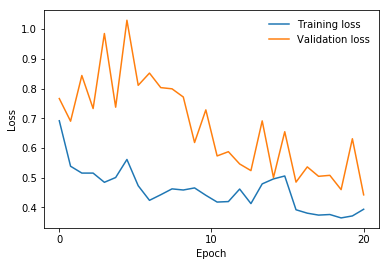

0.45747669755804293
0.6716555660324437


In [7]:
plt.plot(np.linspace(0,epochs,len(train_losses)),train_losses, label='Training loss')
plt.plot(np.linspace(0,epochs,len(test_losses)),test_losses, label='Validation loss')
plt.xticks(range(0,epochs+1,10))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()
from statistics import mean
print(mean(train_losses))
print(mean(test_losses))

In [8]:
torch.save(model.state_dict(), 'classification_nonormalize_backgorund_2cat_20epochs_HandTennis.pth')